In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.cm as cm
import scipy.stats
from matplotlib import pyplot as plt 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

# prevent tensorflow from allocating the entire GPU memory at once
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

In [2]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score,  roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

def one_hot(target, n_classes):
    targets = np.array([target]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return one_hot_targets



def evaluation_metrics(y_true, y_pred, print_result=True):
    acc = 0
    auc = 0
    auc_sk = 0
    #mi = 0
    nmi = 0
    #ami = 0
    bacc = 0
    
    # Accuracy
    #report = classification_report(y_pred.argmax(axis=1), y_true.ravel(), output_dict=True)
    acc = accuracy_score( y_true.ravel(), y_pred.argmax(axis=1))  #report['accuracy']
    
    # Balanced accuracy
    bacc = balanced_accuracy_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze(), adjusted=True)
    
   # # Mutual Information
   # mi = mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Adjusted Mutual Information
    #ami = adjusted_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # AUC (Tensorflow)
    auc_metric = tf.keras.metrics.AUC(from_logits=True)
    auc_metric.update_state(y_true, y_pred.argmax(axis=1).astype('float'))
    auc = auc_metric.result().numpy()
    auc_metric.reset_states()
    
    # AUC (scikit-learn)
    auc_sk = roc_auc_score(one_hot(y_true,10), y_pred)
    
    if print_result:
        print("Accuracy: {:.4f}".format(acc))
        print("Balanced Accuracy: {:.4f}".format(bacc))
        #print("Mutual Information: {:.4f}".format(mi))
        print("Normalized Mutual Information: {:.4f}".format(nmi))
       # print("Adjusted Mutual Information: {:.4f}".format(ami))
        print("AUC (Tensorflow): {:.4f}".format(auc))
        print("AUC (scikit-learn): {:.4f}".format(auc_sk))
    
    return acc, auc, auc_sk, nmi, bacc   # mi, , ami



In [3]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1, neurons=1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q
        self.neurons = neurons

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #tf.print(tf.reduce_sum(Y_true[1,:,0]))
        #tf.print(y_true[1,0])
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))
    
    
    def custom_RCDNN_loss(self, y_true, y_pred):  #ytrue \in N x R,  ypred \in N x (R+K) -> PRI->JULI
    
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 

        #Ground truth estimation samples (N) x  Classes(K)
        pred = y_pred[:,self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
        # Annotators reliability prediction: samples (N) x  annotators (R)
        ann_ = y_pred[:,:self.R]
        #Y_true 1-K: samples (N) x  Classes(1-K), annotators (R)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
        #loss computation
        p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        temp1 = ann_*tf.math.log(p_logreg)  
        temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        return -tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        elif self.optimizer == "RMSprop":
            opt = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        elif self.optimizer == "Adagrad":
            opt = tf.keras.optimizers.Adagrad(learning_rate=self.learning_rate)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        #input_l_b = tf.keras.layers.BatchNormalization()(input_l)        
       # input_l_do = tf.keras.layers.Dropout(rate=self.dropout)(input_l_b)    
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*self.neurons*(self.K+self.R)),activation='selu',name='h1', 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        #h1 = tf.keras.layers.BatchNormalization()(h1)        
        h1 = tf.keras.layers.Dropout(rate=self.dropout)(h1)      
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        #h2 = tf.keras.layers.BatchNormalization()(h2)     
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        output_R = tf.keras.layers.Dense(self.R,activation="sigmoid", 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_R_GCCE' )(dout)
 
        output_K = tf.keras.layers.Dense(self.K,activation="softmax", 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_K_GCCE')(dout)
 
        output = tf.keras.layers.concatenate([output_R, output_K])
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=self.custom_RCDNN_loss, optimizer=opt)
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose, shuffle = True)
 
        return self
 
  
#     def fit(self, X, Y):
#         #input X numpy array first dimension samples (N)x features (P)
#         #input Y numpy array vector len = samples (N) x  annotators (R)
#         P = X.shape[1]
#         if self.optimizer == "Adam":
#             opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
#         elif self.optimizer == "SGD":
#             opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
#         else:
#             opt=self.optimizer

#         #capa de entrada
#         input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
#         #capas densas
#         h1 = tf.keras.layers.Dense(int(P*4*(self.K+self.R)),activation='selu',name='h1',
#                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
#         h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
#                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
#         dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
#         output_R = tf.keras.layers.Dense(self.R,activation="sigmoid", 
#                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_R_GCCE' )(dout)
 
#         output_K = tf.keras.layers.Dense(self.K,activation="softmax", 
#                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_K_GCCE')(dout)
 
#         output = tf.keras.layers.concatenate([output_R, output_K])
#         self.model = tf.keras.Model(inputs= input_l,outputs=output)
#         self.model.compile(loss=self.GCCE_MA_loss, optimizer=opt)
 
#         self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
#                                       batch_size=self.batch_size,verbose=self.verbose)
 
#         return self
 
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
    
    def model_MC(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
        return  self.model(X, training=True) 
 
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


# Cifar-10H dataset for multiple annotators

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import cv2
import os
import time
import sys
import pickle

In [5]:
#cargar datos desde drive acceso libre 
FILEID = "1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Cifar-10H.zip && rm -rf /tmp/cookies.txt
!unzip -o Cifar-10H.zip
!dir

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-02-15 03:54:55--  https://docs.google.com/uc?export=download&confirm=t&id=1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L
Resolving docs.google.com (docs.google.com)... 173.194.211.138, 173.194.211.101, 173.194.211.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.211.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/er6df3ucc6isa0rb34kqrteursdb5mi5/1676433225000/07591141114418430227/*/1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L?e=download&uuid=11f415d4-09b9-4d12-a201-c5770ed8ca1a [following]
--2023-02-15 03:54:56--  https://doc-08-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/er6df3ucc6isa0rb34kqrteursdb5mi5/1676433225000/07591141114418430227/*/1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L?e=download&uuid=11f415d4-09b9-4d12-a201-c5770ed8ca1a
Res

## Training data

In [6]:
Data_dir = '/kaggle/working/Cifar-10H/test_batch'   
labels_dir = '/kaggle/working/Cifar-10H/Answers_Processed.csv'

In [7]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
def arr_to_im(X):
  N = X.shape[0]
  X_tr = np.zeros((N,32,32,3))
  for i,x in enumerate(X):
    aux = x.reshape(3,32,32)/255
    aux = aux.transpose(1,2,0)
    X_tr[i,:] = cv2.resize(aux, (32,32))
  return X_tr

In [9]:
X = unpickle(Data_dir)[b'data']
Label = pd.read_csv(labels_dir, header=None)
Label = Label.to_numpy()
Y = Label[:,:-1]
y = Label[:,-1][:,np.newaxis]
N, R = Y.shape
K = len(np.unique(y))
# y = Label[:,np.newaxis]

In [10]:
# Se eliminan las muestras que no fueron etiquetadas por ningun anotador
idx_ = np.sum(Y,axis=1) != R*(-999)
X = X[idx_,:]
Y = Y[idx_,:]
N, R = Y.shape
y = y[idx_,:]
X = arr_to_im(X)

## Test data

In [11]:
Test_dir = '/kaggle/working/Cifar-10H/data_batch_1'

In [12]:
X_te = unpickle(Test_dir)[b'data']
X_te = arr_to_im(X_te)
y_te = np.array(unpickle(Test_dir)[b'labels'])[:,np.newaxis]

## Ground truth Model

In [13]:
train_batches = tf.data.Dataset.from_tensor_slices((X,y))
test_batches = tf.data.Dataset.from_tensor_slices((X_te,y_te))

In [14]:
y_te.ravel()

array([6, 9, 9, ..., 1, 1, 5])

In [15]:
image_count_train = tf.data.experimental.cardinality(train_batches).numpy()
image_count_train

9233

In [16]:
image_count_test = tf.data.experimental.cardinality(test_batches).numpy()
image_count_test

10000

In [17]:
subset = 7000
test_batches1 = test_batches.take(subset)
image_count1 = tf.data.experimental.cardinality(test_batches1).numpy()
image_count1

7000

In [18]:
image_count = 3000
 
val_size = int(image_count)
test_batches =test_batches.skip(val_size)
val_batches = test_batches.take(val_size)

In [19]:
tf.data.experimental.cardinality(test_batches).numpy()

7000

In [20]:
tf.data.experimental.cardinality(val_batches).numpy()


3000

In [21]:
val_batches = test_batches.shuffle(1024).batch(32)
train_batches = train_batches.shuffle(1024).batch(32)
test_batches = test_batches.shuffle(1024).batch(128)

In [22]:
print(type(test_batches))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


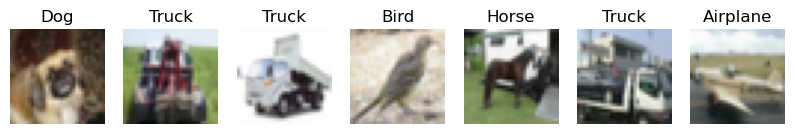

In [23]:
classNames = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


i = 0

fig, ax = plt.subplots(1, 7, figsize=(10,10))
 
for image,label in train_batches.take(1):
  for i in range(7):
    ax[i].axis('off')
    ax[i].set_title(classNames[label[i].numpy().squeeze().astype(int)])
    ax[i].imshow(image[i])
      
 
plt.show()

In [24]:
# def create_model():
#   base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(32, 32, 3),
#   )
#   base_model.trainable = False
#   inputs = keras.Input(shape=(32, 32, 3))
#   # x = keras.layers.Resizing(height=64,width=64,interpolation="bilinear")(inputs)
#   x = base_model(inputs)
#   x = keras.layers.GlobalAveragePooling2D()(x)
#   # x = keras.layers.Dense(128, activation='relu')(x)
#   output = keras.layers.Dense(K,activation='softmax')(x)
#   model = keras.Model(inputs=inputs,outputs=output)
#   return model

In [25]:
def create_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=100)
    l1_param = 1e-4
    num_filters2=32
    model = Sequential()

    model.add(Conv2D(num_filters2, (3, 3), input_shape=(32,32,3), activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block1_conv1") )
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Conv2D(num_filters2, (3, 3),  activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block1_conv2"))
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(2*num_filters2,(3, 3), activation="relu",  #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block2_conv1") )
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Conv2D(2*num_filters2, (3, 3),  activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block2_conv2") )
    model.add(BatchNormalization())
   # model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(4*num_filters2,(3, 3), activation="relu",  #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block3_conv1") )
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Conv2D(4*num_filters2, (3, 3),  activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block3_conv2") )
    model.add(BatchNormalization())
   # model.add(Activation('relu'))
   # model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(512,  activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param)) )
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm = 1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    


    return model

In [26]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X)



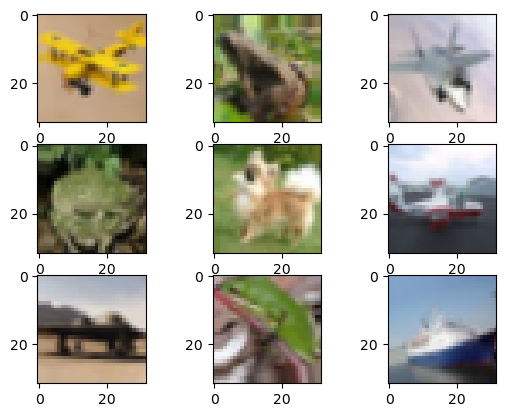

In [27]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(X, y, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

In [28]:
# set up image augmentation
datagen_te = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen_te.fit(X_te)

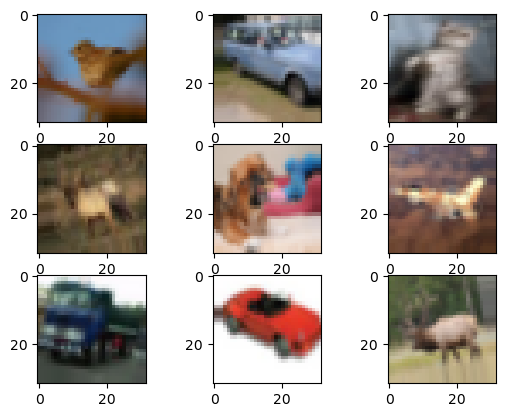

In [29]:
# see example augmentation images
for X_batchte, y_batchte in datagen_te.flow(X_te, y_te, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batchte[i])
    plt.show()
    break

In [30]:
callback1 = tf.keras.callbacks.TerminateOnNaN()
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
#callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                          patience=15, verbose=0, mode="auto",
                                          baseline=None, restore_best_weights=True)


iteration: 0
Epoch 1/70
73/73 [==============================] - 13s 69ms/step - loss: 3.9227 - accuracy: 0.2225
Epoch 2/70
73/73 [==============================] - 5s 65ms/step - loss: 3.3324 - accuracy: 0.2998
Epoch 3/70
73/73 [==============================] - 5s 74ms/step - loss: 3.0373 - accuracy: 0.3634
Epoch 4/70
73/73 [==============================] - 5s 70ms/step - loss: 2.8480 - accuracy: 0.4046
Epoch 5/70
73/73 [==============================] - 5s 65ms/step - loss: 2.6774 - accuracy: 0.4451
Epoch 6/70
73/73 [==============================] - 5s 64ms/step - loss: 2.5429 - accuracy: 0.4698
Epoch 7/70
73/73 [==============================] - 5s 67ms/step - loss: 2.4113 - accuracy: 0.5025
Epoch 8/70
73/73 [==============================] - 5s 64ms/step - loss: 2.3117 - accuracy: 0.5217
Epoch 9/70
73/73 [==============================] - 6s 80ms/step - loss: 2.2028 - accuracy: 0.5457
Epoch 10/70
73/73 [==============================] - 5s 66ms/step - loss: 2.1192 - accuracy: 0.

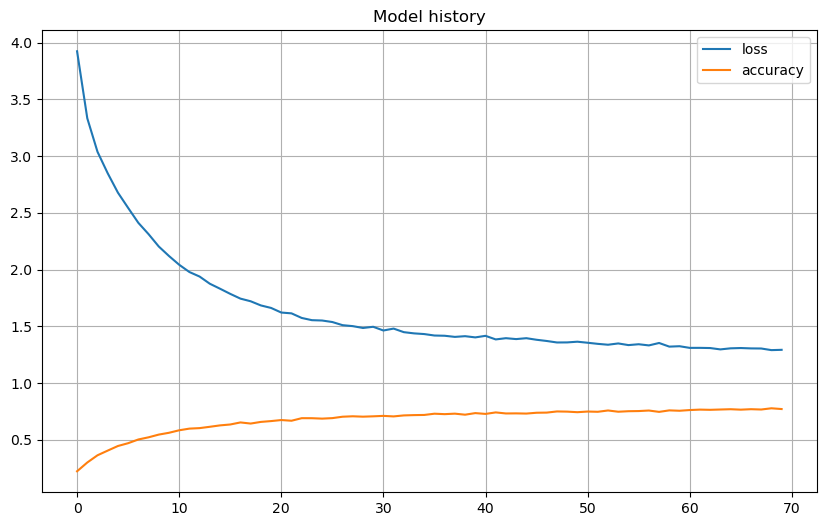

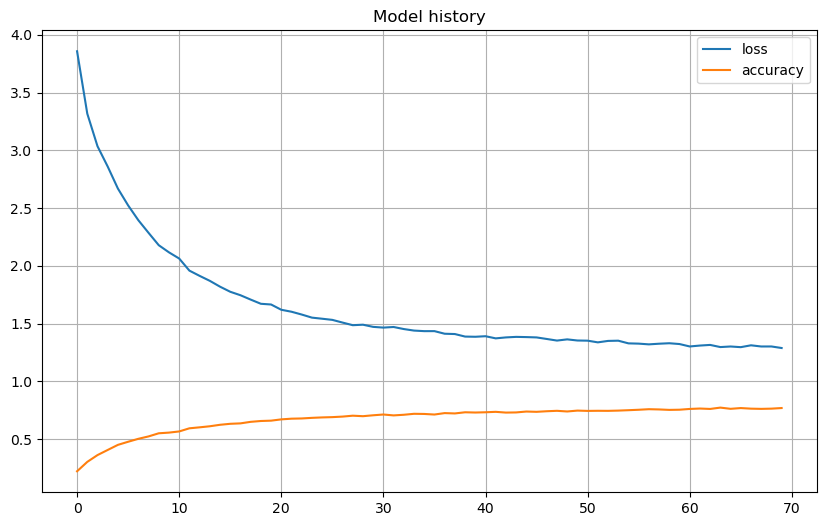

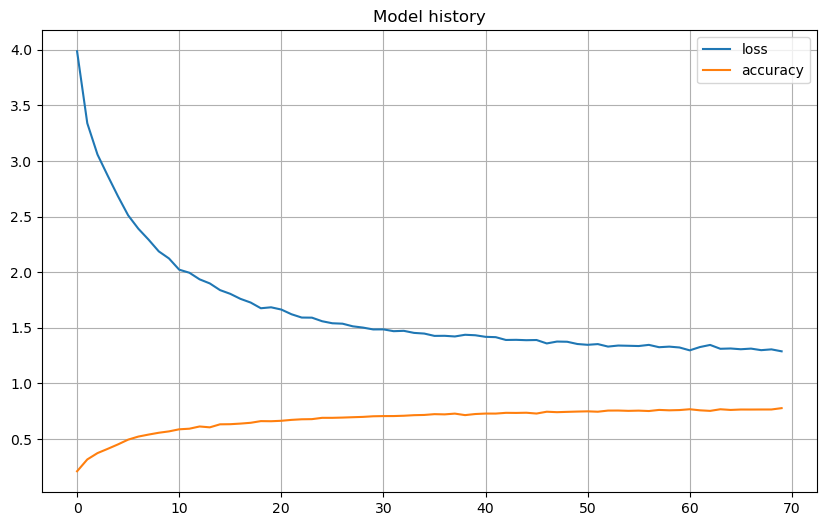

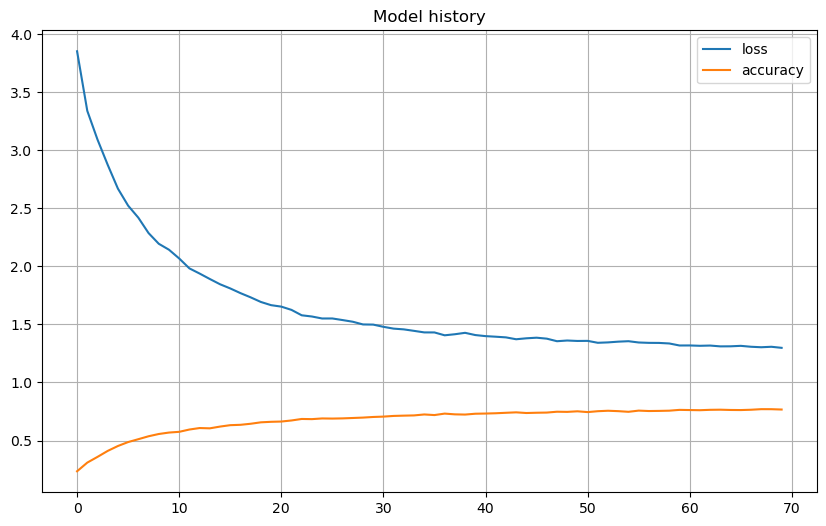

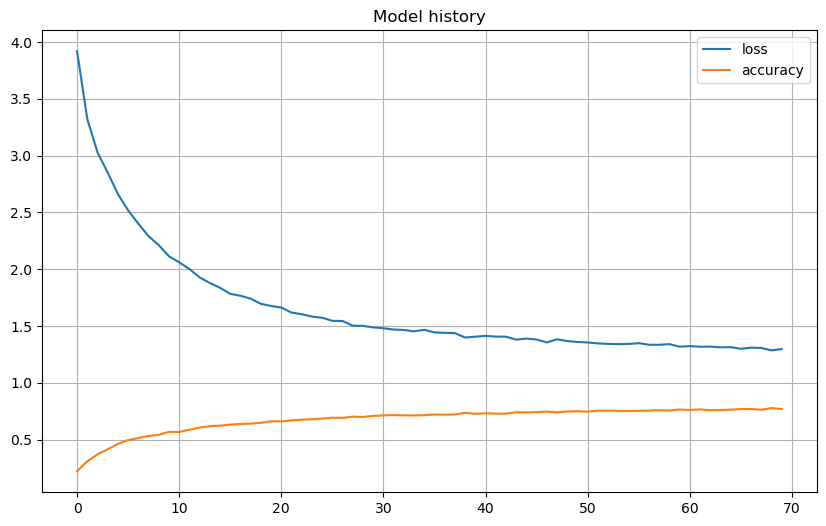

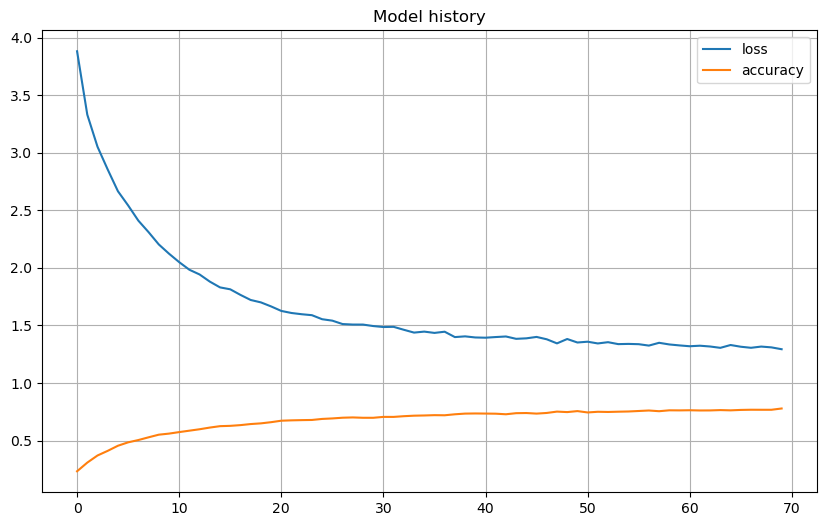

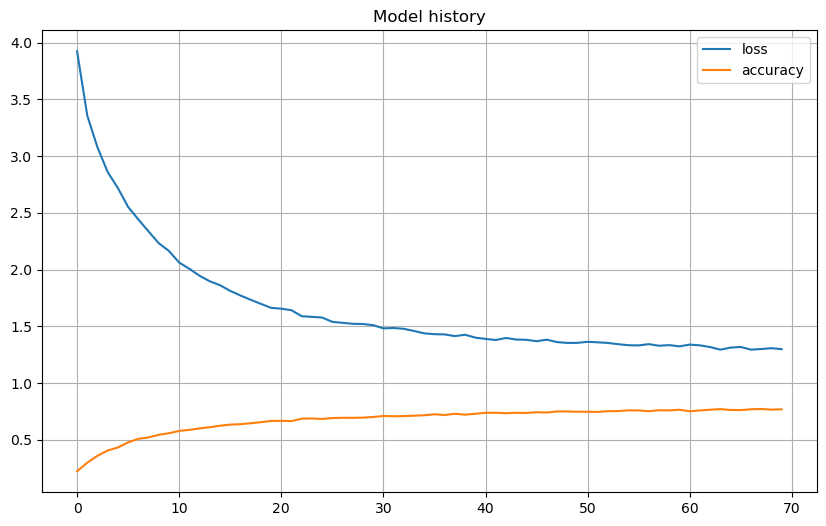

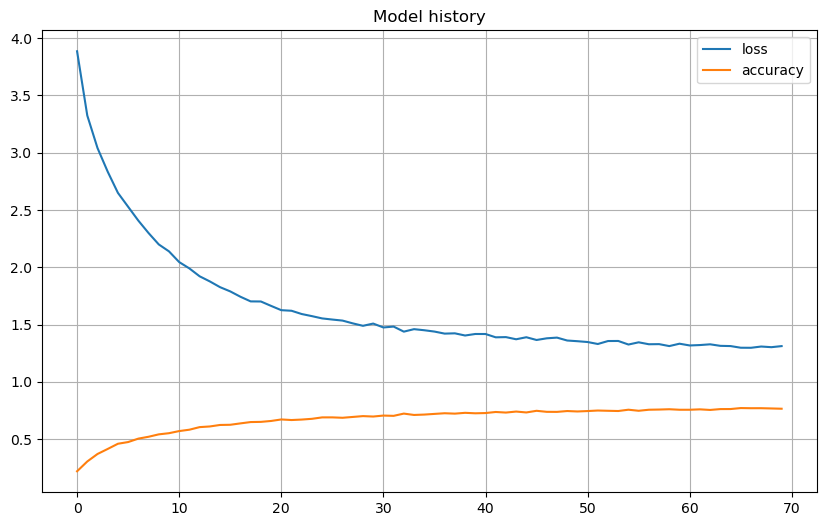

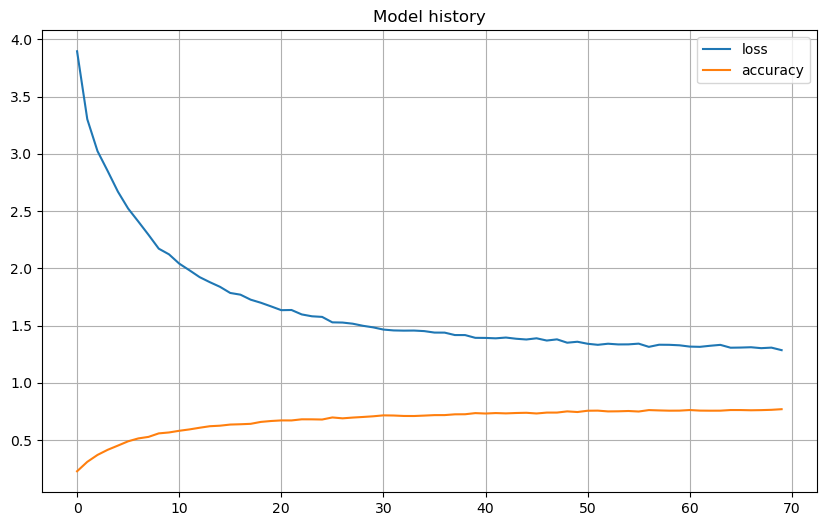

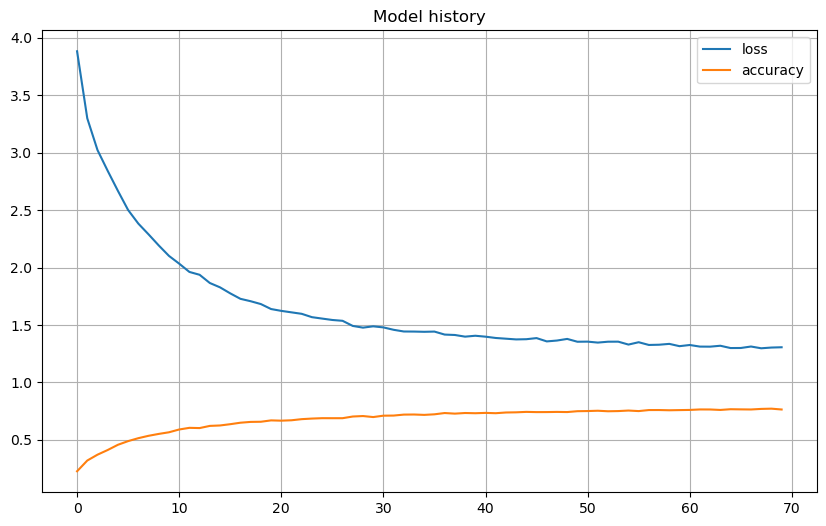

In [31]:
results = []

l1 =0.001
NUM_RUNS = 10

BACC1 = []
MI1 = []
NMI1 =[]
AMI1 = []
AUC1 = []
AUCSK1 = []

N_EPOCHS = 70
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)

for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
    model =  create_model()  
  # datagen_te.flow(X_te, y_te.ravel()
    trainHistory = model.fit(datagen.flow(X, y.ravel(), batch_size=128),  epochs=N_EPOCHS)  #callbacks= [callback1, callback2])
    # Create the history figure
    plt.figure(figsize=(10,6))
    for k in  trainHistory.history:
        plt.plot( trainHistory.history[k],label=k)
    plt.title('Model history')
    plt.legend()
    plt.grid()
  
    #Accuracy
    (loss, accuracy) = model.evaluate(test_batches)
    ACC[i] = accuracy
    print("Validation ACC: %.4f" % (float(ACC[i]),))
    
 
     
    #AUC

    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
    for x_batch_val, y_batch_val in test_batches:
       # print(y_batch_val.numpy())
        val_logits = model(x_batch_val.numpy(), training=False)
       # print(y_batch_val.numpy().ravel())
        #print(val_logits.numpy().argmax(axis=1).squeeze())
        val_AUC_metric.update_state(y_batch_val, val_logits.numpy().argmax(axis=1).astype('float'))
        
        acc, auc, auc_sk,  nmi,  bacc = evaluation_metrics(y_batch_val.numpy(),   val_logits.numpy(), print_result=False)
                                                           
        
        BACC1.append(bacc)
       # MI1.append(mutual_info_score(y_batch_val.numpy().squeeze(), val_logits.numpy().argmax(axis=1).squeeze()))
        NMI1.append( nmi)
        AUCSK1.append(auc_sk)
           
    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
   # print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC

   

   # print("Validation aUc_Sklearn: %.4f" % (float(np.array(AUC1).mean()),))
    #AUC_sk[i] =  np.array(AUC1).mean() 
    
    # balanced. Accurcy
    #BACC[i] = np.array(BACC1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
    #print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
   # MI[i] =  np.array(MI1).mean()  #mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    #print("Validation MI: %.4f" % (float(MI[i]),))
   # NMI[i] =  np.array(NMI1).mean()   #normalized_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
   # print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
   # AMI[i]= np.array(AMI1).mean()  #adjusted_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    #print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


     # Save the results for the current run to the list of dictionaries
    results.append({
        #'run': i,
        'accuracy': accuracy,
        'balanced_accuracy': np.array(BACC1).mean(),
       # 'mutual_information': mi,
        'normalized_mutual_information': np.array(NMI1).mean(),
     #   'adjusted_mutual_information': np.array(AMI1).mean() ,
        'auc_tensorflow': val_AUC,
        'auc_scikit_learn': np.array(AUCSK1).mean() ,
    })
    
    
# Convert the list of dictionaries to a DataFrame
df = np.round(pd.DataFrame(results)*100, 2)

# Calculate the mean and standard deviation of each metric
mean = np.round(df.mean(),2)
std = np.round(df.std(),2)  


In [32]:
df

,accuracy,balanced_accuracy,normalized_mutual_information,auc_tensorflow,auc_scikit_learn
0,70.76,67.92,63.77,81.129997,95.84
1,71.97,68.32,64.03,87.059998,96.00
2,70.93,68.15,63.96,84.290001,95.97
3,72.21,68.42,64.13,84.540001,96.09
4,71.66,68.44,64.20,80.239998,96.14
5,72.71,68.67,64.27,85.209999,96.17
6,72.90,68.86,64.54,82.209999,96.18
7,71.07,68.72,64.38,82.250000,96.16
8,69.70,68.45,64.26,84.989998,96.10
9,73.31,68.64,64.45,85.379997,96.14


In [33]:
mean

accuracy                         71.72
balanced_accuracy                68.46
normalized_mutual_information    64.20
auc_tensorflow                   83.73
auc_scikit_learn                 96.08
dtype: float64

In [34]:
std

accuracy                         1.12
balanced_accuracy                0.28
normalized_mutual_information    0.23
auc_tensorflow                   2.16
auc_scikit_learn                 0.11
dtype: float64

In [35]:
result_df = pd.concat([mean.rename('Mean'), std.rename('Std')], axis=1)

In [36]:
# Save the DataFrame to an excel file
!pip install openpyxl
result_df.to_excel('/kaggle/working/Cifar10HGOLD.xlsx')

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


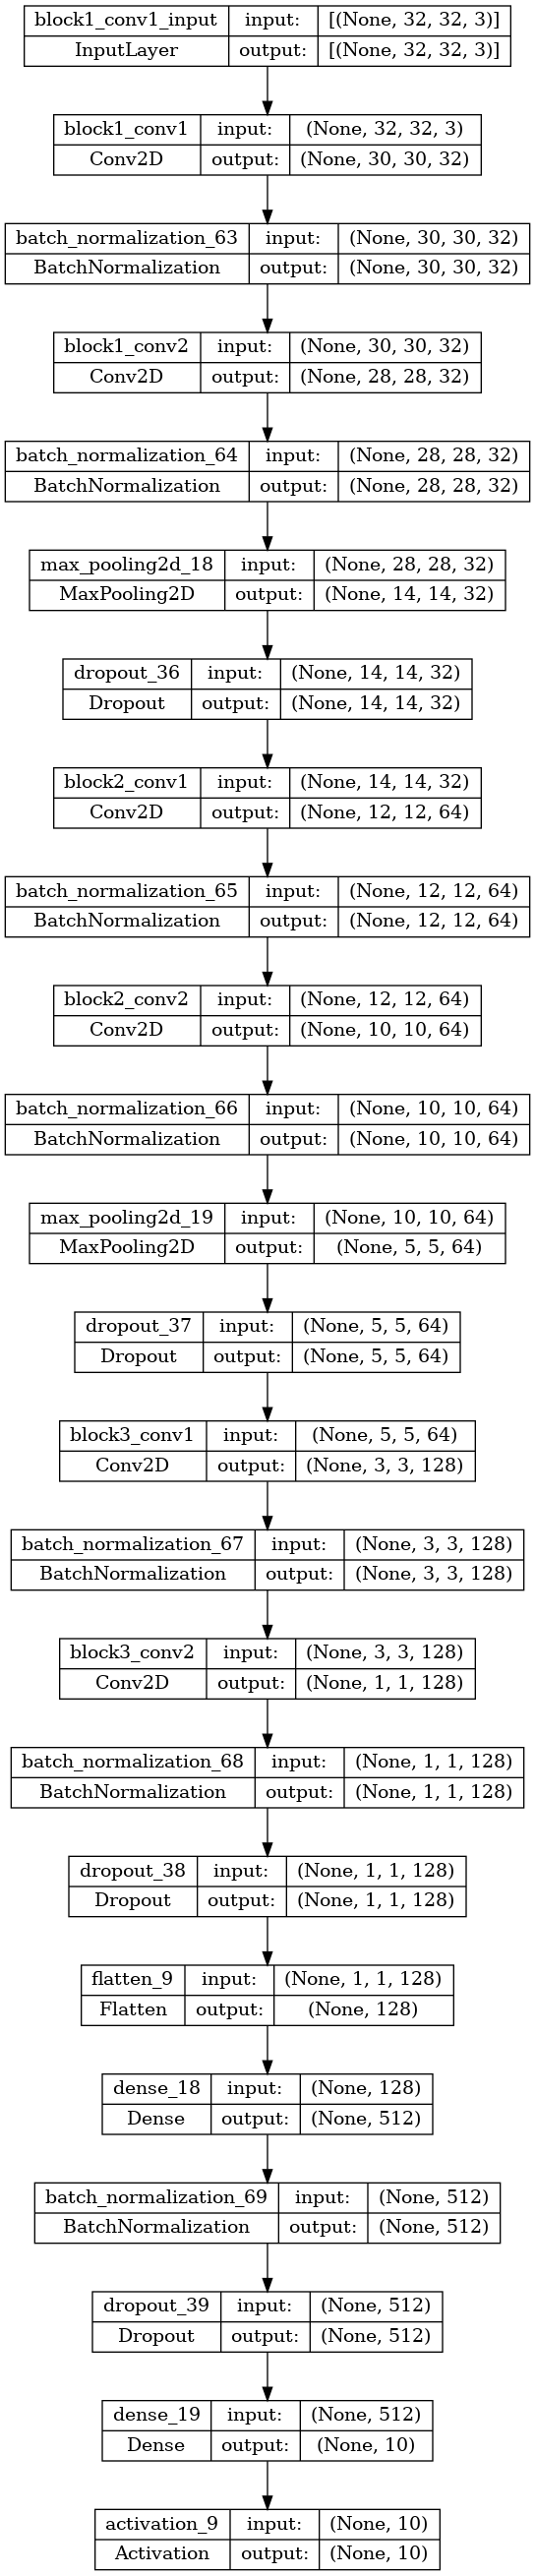

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [38]:
result_df

,Mean,Std
accuracy,71.72,1.12
balanced_accuracy,68.46,0.28
normalized_mutual_information,64.20,0.23
auc_tensorflow,83.73,2.16
auc_scikit_learn,96.08,0.11


## Multiple annotators

In [39]:
# train_batchesMA = tf.data.Dataset.from_tensor_slices((X,y, Y))
# train_batchesMA = train_batchesMA.shuffle(1024).batch(64)

In [40]:
# MA = MultipleAnnotators_Classification(K, R)
# def create_model():
#   base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(32, 32, 3),
#   )
#   base_model.trainable = False
#   inputs = keras.Input(shape=(32, 32, 3))
#   # x = keras.layers.Resizing(height=64,width=64,interpolation="bilinear")(inputs)
#   x = base_model(inputs)
#   x = keras.layers.Flatten()(x)
#   x = keras.layers.Dropout(0.5)(x)
#   x = keras.layers.Dense(256)(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.Dropout(0.5)(x)
#   output = MA.CrowdLayer(x)
#   model = keras.Model(inputs=inputs,outputs=output)
#   return model

In [41]:
# NUM_RUNS = 1
# N_EPOCHS = 50
# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(K, R)
#   model = create_model()
#   model = MA.fit(model, train_batchesMA, N_EPOCHS)
#   val_acc[i] = MA.eval_model(test_batches)
#   print("Validation acc: %.4f" % (float(val_acc[i]),))